# Barrier Option Sensitivity Analysis

This notebook demonstrates how to perform sensitivity analysis on a barrier option's price with respect to its key input parameters using the `BarrierOptionsPricer` class.

## What is Sensitivity Analysis?

Sensitivity analysis involves changing one input parameter at a time while keeping others constant, and observing the effect on the output (in this case, the option price). This helps in understanding:
- **Risk Exposure:** Which parameters have the most significant impact on the option's value (these are related to the option "Greeks" like Delta for $S_0$, Vega for $\sigma$, Rho for $r$).
- **Model Robustness:** How stable the option price is to small changes in inputs.
- **Scenario Planning:** Assessing potential price changes under different market conditions.

We will analyze the sensitivity of a chosen barrier option to parameters such as:
- Initial Asset Price ($S_0$)
- Volatility ($\sigma$)
- Risk-free Rate ($r$)
- Strike Price ($K$)
- Barrier Level ($B$)
- Time to Maturity ($T$)

The `BarrierOptionsPricer` class includes a `sensitivity_analysis` method for this purpose.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Union, Optional, List, Dict # Added List, Dict for type hinting
import time

# For confidence interval calculation - ensure scipy is installed
try:
    from scipy import stats
except ImportError:
    print("Warning: scipy.stats not found. Using a basic approximation for confidence interval critical values.")
    class stats_fallback: # Renamed to avoid conflict
        class norm:
            @staticmethod
            def ppf(q):
                if abs(q - 0.975) < 1e-3: return 1.96
                elif abs(q - 0.995) < 1e-3: return 2.576
                import math # Lazy import math
                # A more robust approximation for inverse normal CDF
                return math.sqrt(2) * math.erfcinv(2.0 - 2.0*q) if q > 0 and q < 1 else 0
    stats = stats_fallback


# Set a seed for reproducibility
np.random.seed(777)


## BarrierOptionsPricer Class and Helper Functions

The following cell contains the full `BarrierOptionsPricer` class definition and the `print_detailed_results` helper function from the `barrier_options_pricer.py` file. We include them here to make the notebook self-contained and runnable.


In [2]:
class BarrierOptionsPricer:
    """
    Monte Carlo pricer for barrier options using Geometric Brownian Motion.
    """
    
    def __init__(self):
        self.valid_option_types = [
            'down_and_out_call', 'down_and_out_put',
            'up_and_out_call', 'up_and_out_put',
            'down_and_in_call', 'down_and_in_put',
            'up_and_in_call', 'up_and_in_put'
        ]
    
    def simulate_gbm_paths(self, S0: float, r: float, sigma: float, T: float, 
                          N_sim: int, N_steps: int) -> np.ndarray:
        dt = T / N_steps
        drift = (r - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt)
        random_shocks = np.random.normal(0, 1, (N_sim, N_steps))
        paths = np.zeros((N_sim, N_steps + 1))
        paths[:, 0] = S0
        for i in range(N_steps):
            paths[:, i + 1] = paths[:, i] * np.exp(drift + diffusion * random_shocks[:, i])
        return paths
    
    def apply_continuity_correction(self, B: float, sigma: float, T: float, 
                                  N_steps: int, option_type: str) -> float:
        dt = T / N_steps
        beta_correction_factor = 0.5826 
        correction_amount = beta_correction_factor * sigma * np.sqrt(dt)
        B_adj = B
        if 'down' in option_type:
            if 'out' in option_type: B_adj = B * np.exp(-correction_amount)
            else: B_adj = B * np.exp(correction_amount)
        elif 'up' in option_type:
            if 'out' in option_type: B_adj = B * np.exp(correction_amount)
            else: B_adj = B * np.exp(-correction_amount)
        return B_adj
    
    def calculate_barrier_payoff(self, path: np.ndarray, K: float, B: float, 
                               option_type: str, T: float, r_rate: float,
                               monitoring_type: str = 'discrete', sigma_for_correction: Optional[float] = None) -> float:
        if option_type not in self.valid_option_types:
            raise ValueError(f"Invalid option type. Must be one of {self.valid_option_types}")
        B_eff = B
        if monitoring_type == 'continuous_approx':
            if sigma_for_correction is None:
                raise ValueError("sigma_for_correction must be provided for continuous_approx monitoring.")
            N_steps = len(path) - 1
            B_eff = self.apply_continuity_correction(B, sigma_for_correction, T, N_steps, option_type)
        knocked_out, knocked_in = False, False
        if ('down_and_out' in option_type and path[0] <= B_eff) or \
           ('up_and_out' in option_type and path[0] >= B_eff):
            return 0.0
        for price_step in path:
            if 'down' in option_type and price_step <= B_eff:
                if 'out' in option_type: knocked_out = True; break
                if 'in' in option_type: knocked_in = True; break
            elif 'up' in option_type and price_step >= B_eff:
                if 'out' in option_type: knocked_out = True; break
                if 'in' in option_type: knocked_in = True; break
        S_T = path[-1]
        intrinsic_payoff = max(S_T - K, 0) if 'call' in option_type else max(K - S_T, 0)
        payoff = 0.0
        if 'out' in option_type and not knocked_out: payoff = intrinsic_payoff
        elif 'in' in option_type and knocked_in: payoff = intrinsic_payoff
        return payoff

    def monte_carlo_pricer(self, S0: float, K: float, B: float, T: float,
                          r_rate: float, sigma: float, option_type: str,
                          N_sim: int, N_steps: int,
                          monitoring_type: str = 'discrete',
                          confidence_level: float = 0.95,
                          antithetic: bool = False) -> Tuple[float, float, float, dict]:
        start_time = time.time()
        actual_N_sim_for_shocks = N_sim
        if antithetic:
            actual_N_sim_for_shocks = (N_sim + 1) // 2 if N_sim % 2 != 0 else N_sim // 2
        
        dt = T / N_steps
        drift = (r_rate - 0.5 * sigma**2) * dt
        diffusion = sigma * np.sqrt(dt)
        random_shocks_orig = np.random.normal(0, 1, (actual_N_sim_for_shocks, N_steps))
        all_payoffs = []

        paths_orig = np.zeros((actual_N_sim_for_shocks, N_steps + 1))
        paths_orig[:, 0] = S0
        for i in range(N_steps):
            paths_orig[:, i + 1] = paths_orig[:, i] * np.exp(drift + diffusion * random_shocks_orig[:, i])
        for j in range(actual_N_sim_for_shocks):
            payoff_orig = self.calculate_barrier_payoff(paths_orig[j,:], K, B, option_type, T, r_rate, monitoring_type, sigma)
            all_payoffs.append(payoff_orig)

        if antithetic:
            random_shocks_anti = -random_shocks_orig
            paths_anti = np.zeros((actual_N_sim_for_shocks, N_steps + 1))
            paths_anti[:, 0] = S0
            for i in range(N_steps):
                paths_anti[:, i + 1] = paths_anti[:, i] * np.exp(drift + diffusion * random_shocks_anti[:, i])
            for j in range(actual_N_sim_for_shocks):
                payoff_anti = self.calculate_barrier_payoff(paths_anti[j,:], K, B, option_type, T, r_rate, monitoring_type, sigma)
                all_payoffs.append(payoff_anti)
        
        all_payoffs_arr = np.array(all_payoffs)
        mean_payoff = np.mean(all_payoffs_arr) if len(all_payoffs_arr) > 0 else 0.0
        option_price = mean_payoff * np.exp(-r_rate * T)
        
        std_payoffs = np.std(all_payoffs_arr, ddof=1) if len(all_payoffs_arr) > 1 else 0.0
        n_total_effective_paths = len(all_payoffs_arr)
        standard_error_payoff = std_payoffs / np.sqrt(n_total_effective_paths) if n_total_effective_paths > 0 else 0.0
        
        alpha_ci = 1 - confidence_level
        critical_value = stats.norm.ppf(1 - alpha_ci/2)
        margin_of_error_price = critical_value * standard_error_payoff * np.exp(-r_rate * T)
        confidence_lower = option_price - margin_of_error_price
        confidence_upper = option_price + margin_of_error_price
        
        computation_time = time.time() - start_time
        mc_error_price_val = standard_error_payoff * np.exp(-r_rate * T)
        
        barrier_hit_count = 0
        combined_paths_for_stats = paths_orig
        if antithetic and actual_N_sim_for_shocks > 0:
            paths_anti_for_stats = np.zeros((actual_N_sim_for_shocks, N_steps + 1))
            paths_anti_for_stats[:, 0] = S0
            for k_sim_idx in range(actual_N_sim_for_shocks): # Corrected variable name
                 for i_step in range(N_steps): # Corrected variable name
                    paths_anti_for_stats[k_sim_idx, i_step + 1] = paths_anti_for_stats[k_sim_idx, i_step] * np.exp(drift + diffusion * (-random_shocks_orig[k_sim_idx, i_step]))
            combined_paths_for_stats = np.vstack((paths_orig, paths_anti_for_stats))

        for path_stat in combined_paths_for_stats:
            B_eff_stat = B
            if monitoring_type == 'continuous_approx':
                 B_eff_stat = self.apply_continuity_correction(B, sigma, T, N_steps, option_type)
            hit_this_path = False
            if 'down' in option_type:
                if np.any(path_stat <= B_eff_stat): hit_this_path = True
            elif 'up' in option_type:
                if np.any(path_stat >= B_eff_stat): hit_this_path = True
            if hit_this_path: barrier_hit_count +=1
        
        barrier_hit_percentage = (barrier_hit_count / len(combined_paths_for_stats)) * 100 if len(combined_paths_for_stats) > 0 else 0.0

        statistics = {
            'mean_payoff': mean_payoff, 'std_payoff': std_payoffs,
            'standard_error_payoff': standard_error_payoff, 'mc_error_price': mc_error_price_val,
            'barrier_hit_percentage': barrier_hit_percentage, 'computation_time': computation_time,
            'effective_simulations_used': n_total_effective_paths, 'confidence_used': confidence_level,
            'convergence_ratio': mc_error_price_val / option_price if abs(option_price) > 1e-9 else float('inf')
        }
        return option_price, confidence_lower, confidence_upper, statistics

    def analyze_convergence(self, S0: float, K: float, B: float, T: float,
                           r_rate: float, sigma: float, option_type: str,
                           N_steps: int, sim_counts: Optional[List[int]] = None,
                           monitoring_type: str = 'discrete', antithetic: bool = False) -> Dict:
        if sim_counts is None:
            sim_counts = [1000, 5000, 10000, 20000, 50000, 100000, 200000, 500000]
        prices, errors, times = [], [], []
        for N_sim_val in sim_counts:
            price, _, _, stats = self.monte_carlo_pricer(
                S0, K, B, T, r_rate, sigma, option_type, N_sim_val, N_steps, monitoring_type, antithetic=antithetic
            )
            prices.append(price)
            errors.append(stats['mc_error_price'])
            times.append(stats['computation_time'])
        return {'sim_counts': sim_counts, 'prices': prices, 'errors': errors, 'computation_times': times}

    def sensitivity_analysis(self, S0: float, K: float, B: float, T: float,
                           r_rate: float, sigma: float, option_type: str,
                           N_sim: int, N_steps: int,
                           parameter_to_vary: str, range_pct: float = 0.2, # Increased default range
                           num_points: int = 11, # Ensure odd number for a center point
                           monitoring_type: str = 'discrete', antithetic: bool = False) -> Dict:
        """
        Perform sensitivity analysis on a specified parameter.
        """
        base_params = {'S0': S0, 'K': K, 'B': B, 'T': T, 'r_rate': r_rate, 'sigma': sigma}
        
        if parameter_to_vary not in base_params:
            raise ValueError(f"Invalid parameter to vary: {parameter_to_vary}. Choose from {list(base_params.keys())}")
            
        base_value = base_params[parameter_to_vary]
        
        min_val = base_value * (1 - range_pct)
        max_val = base_value * (1 + range_pct)
        # Ensure barrier B does not cross S0 in an invalid way during sensitivity
        if parameter_to_vary == 'B':
            if 'down' in option_type and max_val >= S0 : max_val = S0 * 0.999 
            if 'up' in option_type and min_val <= S0 : min_val = S0 * 1.001
            if min_val <=0 : min_val = 0.01 # Ensure barrier is positive
        if parameter_to_vary == 'S0':
             if 'down' in option_type and min_val <= B : min_val = B * 1.001
             if 'up' in option_type and max_val >= B : max_val = B * 0.999


        param_values = np.linspace(min_val, max_val, num_points)
        if parameter_to_vary == 'sigma' or parameter_to_vary == 'r_rate': # Ensure non-negative sigma, r
            param_values = np.maximum(param_values, 0.001 if parameter_to_vary == 'sigma' else -0.5) # Allow negative rates but very small sigma
        
        prices_sensitivity = [] # Renamed to avoid conflict
        
        print(f"Starting sensitivity analysis for parameter: {parameter_to_vary}")
        for i, param_val in enumerate(param_values):
            current_params_iter = base_params.copy() # Use .copy()
            current_params_iter[parameter_to_vary] = param_val
            print(f"  Running for {parameter_to_vary} = {param_val:.4f} ({i+1}/{num_points})")
            
            price, _, _, _ = self.monte_carlo_pricer(
                current_params_iter['S0'], current_params_iter['K'], current_params_iter['B'],
                current_params_iter['T'], current_params_iter['r_rate'], current_params_iter['sigma'],
                option_type, N_sim, N_steps, monitoring_type, antithetic=antithetic
            )
            prices_sensitivity.append(price)
        print("Sensitivity analysis complete.")
        
        # Find index of base value or closest to it
        base_price_idx = np.argmin(np.abs(param_values - base_value))

        return {
            'parameter_varied': parameter_to_vary,
            'parameter_values': param_values,
            'option_prices': prices_sensitivity,
            'base_parameter_value': base_value,
            'base_option_price': prices_sensitivity[base_price_idx]
        }

# Helper function to print results (can be simplified or omitted for this notebook's focus)
def print_detailed_results(price: float, conf_lower: float, conf_upper: float, 
                          stats: dict, option_params: dict):
    print(f"\nOption Price for {option_params['option_type']}: ${price:.6f}")
    print(f"  {stats['confidence_used']*100:.0f}% CI: [${conf_lower:.6f}, ${conf_upper:.6f}] (Error: ±${stats['mc_error_price']:.6f})")
    # Add more stats printing if desired



## Define Base Parameters for Sensitivity Analysis

We'll set up a base case for a specific barrier option. The sensitivity analysis will then vary one parameter around its base value while keeping others fixed.


In [3]:
# Base parameters for the option to be analyzed
base_option_params = {
    'S0': 100.0,
    'K': 100.0,
    'B': 90.0,  # Barrier for a down-and-out call
    'T': 1.0,
    'r_rate': 0.05,
    'sigma': 0.20,
    'option_type': 'down_and_out_call',
    'N_sim': 50000,  # Number of simulations for each sensitivity point (can be reduced for speed)
    'N_steps': 100,   # Number of time steps
    'monitoring_type': 'discrete',
    'antithetic': True # Using antithetic for better stability in sensitivity
}

print("Base Option Parameters for Sensitivity Analysis:")
for key, value in base_option_params.items():
    print(f"- {key}: {value}")


Base Option Parameters for Sensitivity Analysis:
- S0: 100.0
- K: 100.0
- B: 90.0
- T: 1.0
- r_rate: 0.05
- sigma: 0.2
- option_type: down_and_out_call
- N_sim: 50000
- N_steps: 100
- monitoring_type: discrete
- antithetic: True


## Perform Sensitivity Analysis

We'll instantiate the pricer and use the `sensitivity_analysis` method. Let's analyze the sensitivity to:
1.  Initial Stock Price ($S_0$)
2.  Volatility ($\sigma$)
3.  Barrier Level ($B$)


In [4]:
pricer_sens_analyzer = BarrierOptionsPricer()

# --- 1. Sensitivity to Initial Stock Price (S0) ---
param_to_analyze_S0 = 'S0'
sensitivity_S0_results = pricer_sens_analyzer.sensitivity_analysis(
    **base_option_params,  # Unpack base parameters
    parameter_to_vary=param_to_analyze_S0,
    range_pct=0.2, # Vary S0 by +/- 20%
    num_points=11  # Number of S0 values to test
)

# --- 2. Sensitivity to Volatility (sigma) ---
param_to_analyze_sigma = 'sigma'
sensitivity_sigma_results = pricer_sens_analyzer.sensitivity_analysis(
    **base_option_params,
    parameter_to_vary=param_to_analyze_sigma,
    range_pct=0.5, # Vary sigma by +/- 50% (volatility can have a large impact)
    num_points=11
)

# --- 3. Sensitivity to Barrier Level (B) ---
# For a Down-and-Out Call, the barrier B < S0. We need to ensure the range is valid.
# The sensitivity_analysis method has some basic checks, but let's be mindful.
param_to_analyze_B = 'B'
# Adjust range_pct for barrier to ensure B stays below S0 and is positive
# Base B is 90, S0 is 100. Range_pct of 0.05 means 90 +/- 4.5 (85.5 to 94.5)
sensitivity_B_results = pricer_sens_analyzer.sensitivity_analysis(
    **base_option_params,
    parameter_to_vary=param_to_analyze_B,
    range_pct=0.05, 
    num_points=11
)


Starting sensitivity analysis for parameter: S0
  Running for S0 = 90.0900 (1/11)
  Running for S0 = 93.0810 (2/11)
  Running for S0 = 96.0720 (3/11)
  Running for S0 = 99.0630 (4/11)
  Running for S0 = 102.0540 (5/11)
  Running for S0 = 105.0450 (6/11)
  Running for S0 = 108.0360 (7/11)
  Running for S0 = 111.0270 (8/11)
  Running for S0 = 114.0180 (9/11)
  Running for S0 = 117.0090 (10/11)
  Running for S0 = 120.0000 (11/11)
Sensitivity analysis complete.
Starting sensitivity analysis for parameter: sigma
  Running for sigma = 0.1000 (1/11)
  Running for sigma = 0.1200 (2/11)
  Running for sigma = 0.1400 (3/11)
  Running for sigma = 0.1600 (4/11)
  Running for sigma = 0.1800 (5/11)
  Running for sigma = 0.2000 (6/11)
  Running for sigma = 0.2200 (7/11)
  Running for sigma = 0.2400 (8/11)
  Running for sigma = 0.2600 (9/11)
  Running for sigma = 0.2800 (10/11)
  Running for sigma = 0.3000 (11/11)
Sensitivity analysis complete.
Starting sensitivity analysis for parameter: B
  Running f

## Plotting Sensitivity Results

Let's visualize how the option price changes with each varied parameter.


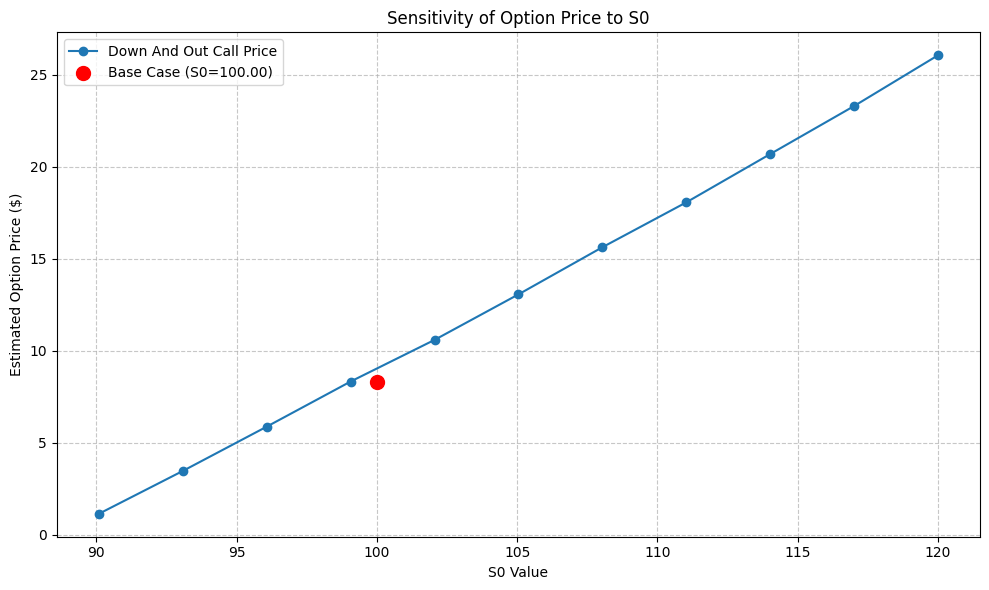

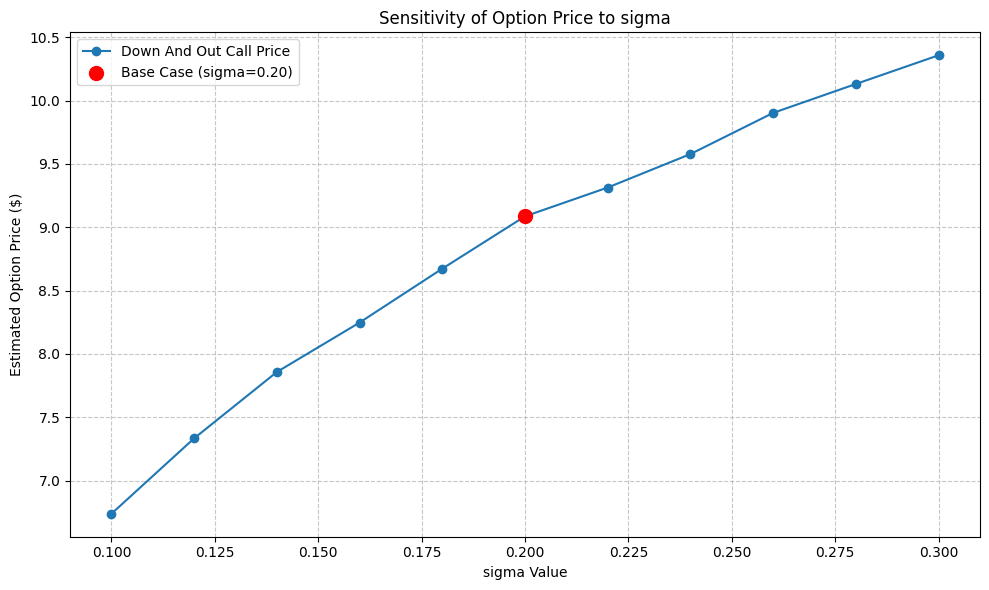

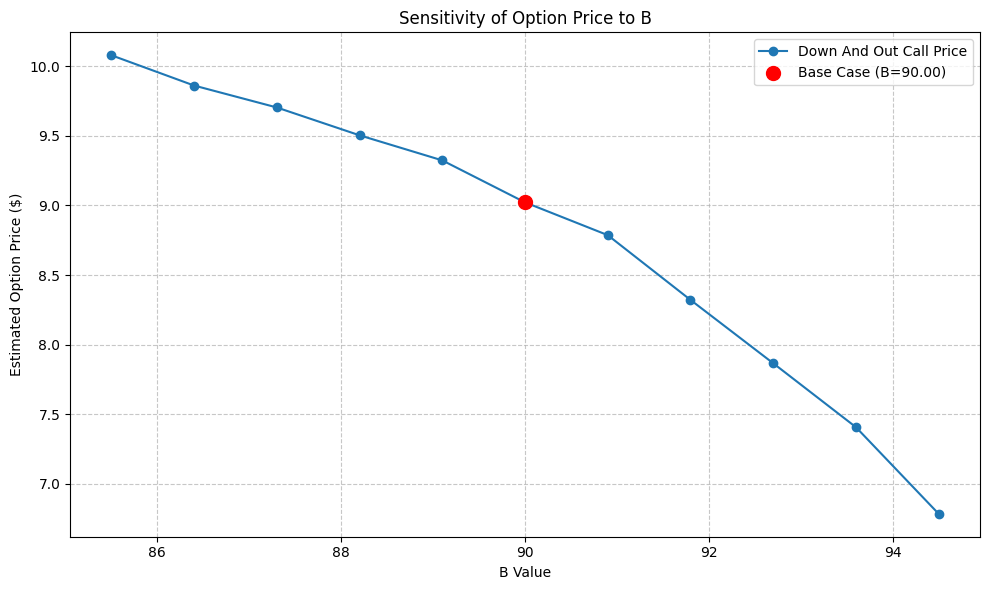

\nSummary of Sensitivity to S0:
S0 Value        Option Price ($)
90.09           1.147482       
93.08           3.474072       
96.07           5.880197       
99.06           8.332532       
102.05          10.593746      
105.04          13.067204      
108.04          15.627552      
111.03          18.066197      
114.02          20.689351      
117.01          23.298848      
120.00          26.056732      
\nSummary of Sensitivity to Sigma:
Sigma Value     Option Price ($)
0.1000          6.737840       
0.1200          7.333427       
0.1400          7.857441       
0.1600          8.247699       
0.1800          8.673370       
0.2000          9.086694       
0.2200          9.314210       
0.2400          9.578360       
0.2600          9.903584       
0.2800          10.131861      
0.3000          10.358510      
\nSummary of Sensitivity to Barrier (B):
Barrier Value   Option Price ($)
85.50           10.079444      
86.40           9.861799       
87.30           9.704177 

In [5]:
def plot_sensitivity(sensitivity_results: Dict, base_option_type: str):
    """Helper function to plot sensitivity analysis results."""
    param_name = sensitivity_results['parameter_varied']
    param_values = sensitivity_results['parameter_values']
    option_prices = sensitivity_results['option_prices']
    base_param_val = sensitivity_results['base_parameter_value']
    base_opt_price = sensitivity_results['base_option_price']

    plt.figure(figsize=(10, 6))
    plt.plot(param_values, option_prices, marker='o', linestyle='-', label=f'{base_option_type.replace("_", " ").title()} Price')
    plt.scatter([base_param_val], [base_opt_price], color='red', s=100, zorder=5, label=f'Base Case ({param_name}={base_param_val:.2f})')
    
    plt.title(f'Sensitivity of Option Price to {param_name}')
    plt.xlabel(f'{param_name} Value')
    plt.ylabel('Estimated Option Price ($)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot results for S0
plot_sensitivity(sensitivity_S0_results, base_option_params['option_type'])

# Plot results for sigma
plot_sensitivity(sensitivity_sigma_results, base_option_params['option_type'])

# Plot results for Barrier B
plot_sensitivity(sensitivity_B_results, base_option_params['option_type'])

print("\\nSummary of Sensitivity to S0:")
print(f"{'S0 Value':<15} {'Option Price ($)':<15}")
for pv, op in zip(sensitivity_S0_results['parameter_values'], sensitivity_S0_results['option_prices']):
    print(f"{pv:<15.2f} {op:<15.6f}")

print("\\nSummary of Sensitivity to Sigma:")
print(f"{'Sigma Value':<15} {'Option Price ($)':<15}")
for pv, op in zip(sensitivity_sigma_results['parameter_values'], sensitivity_sigma_results['option_prices']):
    print(f"{pv:<15.4f} {op:<15.6f}")

print("\\nSummary of Sensitivity to Barrier (B):")
print(f"{'Barrier Value':<15} {'Option Price ($)':<15}")
for pv, op in zip(sensitivity_B_results['parameter_values'], sensitivity_B_results['option_prices']):
    print(f"{pv:<15.2f} {op:<15.6f}")


## Conclusion and Observations

From the sensitivity plots, we can typically observe:

-   **Sensitivity to $S_0$ (Delta-like behavior):**
    -   For a call option, the price generally increases as $S_0$ increases.
    -   For a put option, the price generally decreases as $S_0$ increases.
    -   The shape of this curve gives an intuition about the option's Delta. For barrier options, this relationship can be more complex near the barrier.

-   **Sensitivity to Volatility ($\sigma$) (Vega-like behavior):**
    -   Generally, option prices (both calls and puts, including barriers) increase with higher volatility, as it increases the chance of favorable price movements (and for barrier options, increases the chance of hitting an 'in' barrier or avoiding an 'out' barrier, depending on the type).
    -   This relationship shows the option's Vega.

-   **Sensitivity to Barrier Level ($B$):**
    -   For a **Down-and-Out** option, as the barrier $B$ increases (gets closer to $S_0$ from below), the option price tends to decrease because the probability of knockout increases. If $B$ decreases (moves further away), the price increases, approaching a standard European option if $B$ is very far.
    -   For an **Up-and-Out** option, as $B$ decreases (gets closer to $S_0$ from above), the price decreases. If $B$ increases (moves further away), the price increases.
    -   For **'In'** options, the relationship is often reversed: a barrier closer to $S_0$ might increase the probability of knock-in and thus the option value, up to a point.

This type of analysis is crucial for risk management and for understanding the drivers of an option's value. The specific shapes of these sensitivity curves can be unique to barrier options due to their path-dependent nature.
